# MLDL2 Homework : Semi-Supervised Learning & Self-Supervised Learning

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn.functional as F
from tqdm import tqdm

# Dataset

In [2]:
# Feel free to incorporate additional transforms, such as data augmentation.
transform = transforms.Compose(
    [
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
BATCH_SIZE = 32


## **Do not modify the cell below!!!!**


In [3]:
train_dataset = datasets.CIFAR10(root="./data/",
                                 train=True,
                                 download=True,
                                transform=transform
                                 )

val_dataset = datasets.CIFAR10(root="./data/",
                                train=False,
                                download=True,
                                 transform=transform
                                )

num_labeled = 5000
num_unlabeled = len(train_dataset) - num_labeled

indices = list(range(len(train_dataset)))
labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

for idx in unlabeled_indices:
    train_dataset.targets[idx] = -1

labeled_train_dataset = torch.utils.data.Subset(train_dataset, labeled_indices)
unlabeled_train_dataset = torch.utils.data.Subset(train_dataset, unlabeled_indices)

labeled_train_loader = torch.utils.data.DataLoader(dataset=labeled_train_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

unlabeled_train_loader = torch.utils.data.DataLoader(dataset=unlabeled_train_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class val_Dataset2(Dataset):
    def __init__(self,img_file, label_file, transform=None):
        self.img =np.load(img_file)
        self.labels = np.load(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]

        return image,label

In [5]:
val_dataset2 = val_Dataset2(img_file="./valid_dataset2.npy",label_file="./valid_dataset2_label.npy",transform=transform)
val_loader2 = torch.utils.data.DataLoader(val_dataset2, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [6]:
next(iter(val_loader2))

[tensor([[[[-0.9451, -0.8353, -0.8588,  ..., -0.8353, -0.7176, -0.6235],
           [-0.7412, -0.8275, -0.8745,  ..., -0.8824, -0.7098, -0.6000],
           [-0.1922, -0.6549, -0.8902,  ..., -0.9216, -0.6941, -0.5451],
           ...,
           [-0.6863, -0.8667, -0.8667,  ..., -0.8196, -0.7882, -0.7255],
           [-0.6157, -0.8588, -0.8902,  ..., -0.7961, -0.7804, -0.7412],
           [-0.3961, -0.7804, -0.8902,  ..., -0.7412, -0.7490, -0.7569]],
 
          [[-0.8902, -0.8745, -0.9059,  ..., -0.8353, -0.7255, -0.6078],
           [-0.7647, -0.8431, -0.9373,  ..., -0.8824, -0.7176, -0.5922],
           [-0.2314, -0.6627, -0.9451,  ..., -0.9216, -0.7020, -0.5451],
           ...,
           [-0.7725, -0.8118, -0.9216,  ..., -0.7961, -0.7725, -0.7098],
           [-0.7725, -0.8824, -0.9451,  ..., -0.7882, -0.7804, -0.7333],
           [-0.6392, -0.8902, -0.8902,  ..., -0.7412, -0.7490, -0.7412]],
 
          [[-0.9451, -0.8745, -0.9059,  ..., -0.8039, -0.7412, -0.5373],
           [-

In [7]:
print("labeled_train_dataset size : ", len(labeled_train_dataset))
print("unlabeled_train_dataset size : ", len(unlabeled_train_dataset))
print("val_dataset size : ", len(val_dataset))
print("val_dataset2 size : ", len(val_dataset2))

labeled_train_dataset size :  5000
unlabeled_train_dataset size :  45000
val_dataset size :  10000
val_dataset2 size :  9500


/tmp/ipykernel_648223/3088434795.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(labeled_train_dataset[0][0].T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


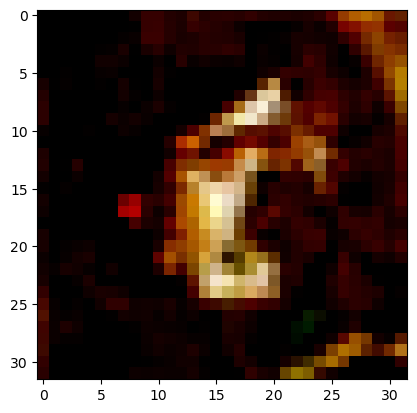

In [8]:
plt.imshow(labeled_train_dataset[0][0].T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


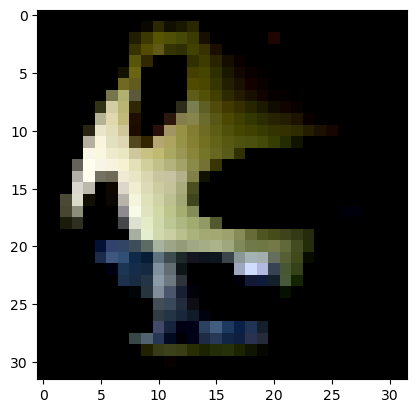

In [9]:
plt.imshow(val_dataset2[0][0].T)

In [10]:
temp = [0]*10
for i in range(5000):
  temp[labeled_train_dataset[i][-1]] = temp[labeled_train_dataset[i][-1]] + 1

In [11]:
temp

[505, 460, 519, 486, 519, 488, 519, 486, 520, 498]

# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler. Below is very simple model with CNN. You can customize your own model and note that you are not limited to use any methods. **But you are not allowed to use pretrained weight**

## 1. Semi-supervised: mean-teacher model

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# define model
model = SimpleCNN()
teacher_model = SimpleCNN()

# Teacher model -> copy student model
teacher_model.load_state_dict(model.state_dict())

model.to(device)
teacher_model.to(device)

# loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

alpha=0.99

print('######## Training #######')

for epoch in tqdm(range(20)):  # loop over the dataset multiple times

    running_loss = 0.0
    acc_loss = []
    teacher_model.eval()

    for i, (data1, data2) in enumerate(zip(labeled_train_loader,unlabeled_train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        sup_inputs, labels = data1[0].to(device), data1[1].to(device)
        unsup_inputs, _ = data2[0].to(device), data2[1]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        sup_outputs = model(sup_inputs)
        sup_loss = criterion(sup_outputs, labels)

        # get pred by using unlabel data
        with torch.no_grad():
            student_outputs = model(unsup_inputs)
            teacher_outputs = teacher_model(unsup_inputs)

        # update teacher model's parm by ema
        for teacher_param, student_param in zip(teacher_model.parameters(), model.parameters()):
            teacher_param.data = alpha * teacher_param.data + (1 - alpha) * student_param.data

        # auxiliary loss: consistency regularization
        aux_loss = F.mse_loss(student_outputs, teacher_outputs)
        loss = sup_loss + alpha * aux_loss
        running_loss += loss
        acc_loss.append(loss.item())

        # if (i % 10 == 0) and (i!=0):
        #     print(f'{i} steps average loss: {running_loss/50}')
        #     running_loss = 0.0

        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}: {np.mean(acc_loss):.2f}')

print('Finished Training')

print()

print('####### Validation #########')

correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

cuda:0
######## Training #######


  5%|▌         | 1/20 [00:01<00:33,  1.79s/it]

Epoch 1: 2.46


 10%|█         | 2/20 [00:03<00:29,  1.66s/it]

Epoch 2: 2.27


 15%|█▌        | 3/20 [00:04<00:27,  1.61s/it]

Epoch 3: 1.87


 20%|██        | 4/20 [00:06<00:25,  1.59s/it]

Epoch 4: 1.75


 25%|██▌       | 5/20 [00:08<00:23,  1.59s/it]

Epoch 5: 1.56


 30%|███       | 6/20 [00:09<00:22,  1.57s/it]

Epoch 6: 1.56


 35%|███▌      | 7/20 [00:11<00:20,  1.56s/it]

Epoch 7: 1.57


 40%|████      | 8/20 [00:12<00:18,  1.56s/it]

Epoch 8: 1.74


 45%|████▌     | 9/20 [00:14<00:17,  1.57s/it]

Epoch 9: 1.73


 50%|█████     | 10/20 [00:15<00:15,  1.57s/it]

Epoch 10: 2.01


 55%|█████▌    | 11/20 [00:17<00:14,  1.58s/it]

Epoch 11: 2.07


 60%|██████    | 12/20 [00:19<00:12,  1.58s/it]

Epoch 12: 2.14


 65%|██████▌   | 13/20 [00:20<00:11,  1.57s/it]

Epoch 13: 1.65


 70%|███████   | 14/20 [00:22<00:09,  1.58s/it]

Epoch 14: 1.37


 75%|███████▌  | 15/20 [00:23<00:07,  1.57s/it]

Epoch 15: 0.38


 80%|████████  | 16/20 [00:25<00:06,  1.56s/it]

Epoch 16: 0.16


 85%|████████▌ | 17/20 [00:26<00:04,  1.56s/it]

Epoch 17: 0.08


 90%|█████████ | 18/20 [00:28<00:03,  1.56s/it]

Epoch 18: 0.04


 95%|█████████▌| 19/20 [00:29<00:01,  1.55s/it]

Epoch 19: 0.02


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]

Epoch 20: 0.02
Finished Training

####### Validation #########


Accuracy of the network on the 10000 test images: 60 %


In [13]:
class TestDataset(Dataset):
    def __init__(self, img_file, transform=None):
        self.img =np.load(img_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform is not None:
            image = self.transform(image)

        return image

test_dataset = TestDataset(img_file="./test_data.npy",transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

def test(model, test_loader):
  model.eval()

  ### List to store predictions
  test_predictions = []

  with torch.inference_mode():
      for i, data in enumerate(tqdm(test_loader)):

          data = data.float().to(device)
          output = model(data)
          ### Get most likely predicted  with argmax
          predicted_labels = torch.argmax(output, dim=1)

          test_predictions.extend(predicted_labels.cpu().tolist())

  return test_predictions

predictions = test(model, test_loader)

### Create CSV file with predictions
path = './{2023-21408}-{jaewonjung}-{semi}-HW3.csv'
with open(path, "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, predictions[i]))

100%|██████████| 30/30 [00:00<00:00, 77.31it/s]


## 2. Self-supervised method: SimCLR

In [14]:
# constrastive learning을 위한 새로운 augmentation 추가
transform2 = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomResizedCrop(32,(0.8,1.0)),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomRotation(degrees=(-30, 30)),
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

train_dataset2 = datasets.CIFAR10(root="./data/",
                                 train=True,
                                 download=True,
                                transform=transform2
                                 )

num_labeled = 5000
num_unlabeled = len(train_dataset2) - num_labeled

indices = list(range(len(train_dataset2)))
labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

for idx in unlabeled_indices:
    train_dataset2.targets[idx] = -1

labeled_train_dataset2 = torch.utils.data.Subset(train_dataset2, labeled_indices)
unlabeled_train_dataset2 = torch.utils.data.Subset(train_dataset2, unlabeled_indices)

labeled_train_loader2 = torch.utils.data.DataLoader(dataset=labeled_train_dataset2,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

unlabeled_train_loader2 = torch.utils.data.DataLoader(dataset=unlabeled_train_dataset2,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False)


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


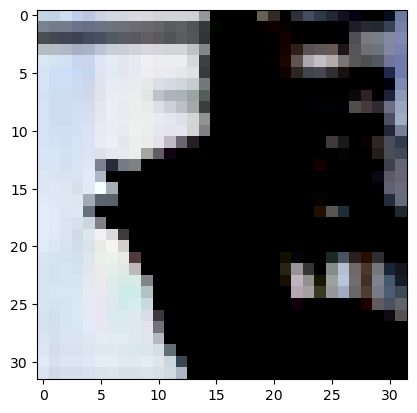

In [15]:
import matplotlib.pyplot as plt

plt.imshow(unlabeled_train_dataset[1][0].T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


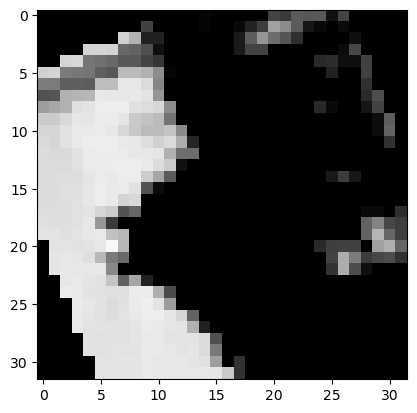

In [16]:
plt.imshow(unlabeled_train_dataset2[1][0].T)

In [17]:
# augmentation이 다른 두 데이터 비교를 위한 pair dataset 정의
class PairedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        assert len(dataset1) == len(dataset2)  # 데이터셋 크기 동일여부 체크

    def __getitem__(self, index):
        x_i, _ = self.dataset1[index]
        x_j,_ = self.dataset2[index]
        return x_i, x_j

    def __len__(self):
        return len(self.dataset1)

paired_dataset = PairedDataset(unlabeled_train_dataset, unlabeled_train_dataset2)
paired_loader = torch.utils.data.DataLoader(paired_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
import torchvision.models as models

class SimCLR(nn.Module):
    def __init__(self):
        super(SimCLR, self).__init__()
        self.encoder = models.resnet18(pretrained=False)  # ResNet-18 사용 (weight 사용x)
        self.encoder.fc = nn.Identity()  # 마지막 fc layer 제거
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128)
        )

    def forward(self, x):
        h = self.encoder(x)  # visual representation
        z = self.projection_head(h)  # projection
        return h, z

# https://medium.com/the-owl/simclr-in-pytorch-5f290cb11dd7 
# loss 부분 참조
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLR().to(device)
criterion = SimCLR_Loss(BATCH_SIZE, temperature = 0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 10

errors = []
for epoch in range(epochs):
    total_loss = 0
    for i, data in tqdm(enumerate(paired_loader)):
        _, origin_vec = model(data[0].to(device))
        _, aug_vec  = model(data[1].to(device))
        
        try:
            loss = criterion(origin_vec, aug_vec)
            total_loss += loss.item()
        except:
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i}/{len(paired_loader)}], Loss: {loss.item():.4f}')


/home/ubuntu/miniforge3/envs/pt20_py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniforge3/envs/pt20_py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
5it [00:00, 17.97it/s]

Epoch [1/10], Step [0/1407], Loss: 4.0067


105it [00:02, 39.20it/s]

Epoch [1/10], Step [100/1407], Loss: 2.9129


205it [00:05, 37.21it/s]

Epoch [1/10], Step [200/1407], Loss: 2.9559


305it [00:08, 39.09it/s]

Epoch [1/10], Step [300/1407], Loss: 3.0097


405it [00:10, 37.61it/s]

Epoch [1/10], Step [400/1407], Loss: 2.6506


505it [00:13, 39.32it/s]

Epoch [1/10], Step [500/1407], Loss: 2.6964


605it [00:15, 39.29it/s]

Epoch [1/10], Step [600/1407], Loss: 2.5879


706it [00:18, 39.22it/s]

Epoch [1/10], Step [700/1407], Loss: 2.5229


806it [00:20, 39.22it/s]

Epoch [1/10], Step [800/1407], Loss: 2.5255


906it [00:23, 39.36it/s]

Epoch [1/10], Step [900/1407], Loss: 2.4792


1006it [00:26, 39.34it/s]

Epoch [1/10], Step [1000/1407], Loss: 2.6072


1106it [00:28, 39.30it/s]

Epoch [1/10], Step [1100/1407], Loss: 2.5423


1206it [00:31, 39.42it/s]

Epoch [1/10], Step [1200/1407], Loss: 2.4426


1306it [00:33, 39.41it/s]

Epoch [1/10], Step [1300/1407], Loss: 2.4352


1407it [00:36, 38.83it/s]


Epoch [1/10], Step [1400/1407], Loss: 2.4255


0it [00:00, ?it/s]

Epoch [2/10], Step [0/1407], Loss: 2.4100


108it [00:02, 39.36it/s]

Epoch [2/10], Step [100/1407], Loss: 2.4043


208it [00:05, 39.18it/s]

Epoch [2/10], Step [200/1407], Loss: 2.4240


308it [00:07, 39.45it/s]

Epoch [2/10], Step [300/1407], Loss: 2.3921


408it [00:10, 39.18it/s]

Epoch [2/10], Step [400/1407], Loss: 2.4132


508it [00:12, 39.46it/s]

Epoch [2/10], Step [500/1407], Loss: 2.3877


608it [00:15, 39.42it/s]

Epoch [2/10], Step [600/1407], Loss: 2.3542


708it [00:18, 39.07it/s]

Epoch [2/10], Step [700/1407], Loss: 2.3528


808it [00:20, 38.52it/s]

Epoch [2/10], Step [800/1407], Loss: 2.3648


908it [00:23, 39.08it/s]

Epoch [2/10], Step [900/1407], Loss: 2.3619


1008it [00:25, 38.65it/s]

Epoch [2/10], Step [1000/1407], Loss: 2.3983


1108it [00:28, 39.10it/s]

Epoch [2/10], Step [1100/1407], Loss: 2.3834


1208it [00:30, 38.95it/s]

Epoch [2/10], Step [1200/1407], Loss: 2.3244


1308it [00:33, 39.16it/s]

Epoch [2/10], Step [1300/1407], Loss: 2.3551


1407it [00:35, 39.18it/s]


Epoch [2/10], Step [1400/1407], Loss: 2.3453


0it [00:00, ?it/s]

Epoch [3/10], Step [0/1407], Loss: 2.4038


108it [00:02, 39.55it/s]

Epoch [3/10], Step [100/1407], Loss: 2.3619


208it [00:05, 39.37it/s]

Epoch [3/10], Step [200/1407], Loss: 2.3671


308it [00:07, 38.99it/s]

Epoch [3/10], Step [300/1407], Loss: 2.3668


408it [00:10, 39.08it/s]

Epoch [3/10], Step [400/1407], Loss: 2.3727


508it [00:12, 39.12it/s]

Epoch [3/10], Step [500/1407], Loss: 2.3485


608it [00:15, 39.15it/s]

Epoch [3/10], Step [600/1407], Loss: 2.3421


708it [00:18, 38.93it/s]

Epoch [3/10], Step [700/1407], Loss: 2.3521


808it [00:20, 39.17it/s]

Epoch [3/10], Step [800/1407], Loss: 2.3309


908it [00:23, 39.27it/s]

Epoch [3/10], Step [900/1407], Loss: 2.3131


1008it [00:25, 39.38it/s]

Epoch [3/10], Step [1000/1407], Loss: 2.3698


1108it [00:28, 39.41it/s]

Epoch [3/10], Step [1100/1407], Loss: 2.3604


1208it [00:30, 39.34it/s]

Epoch [3/10], Step [1200/1407], Loss: 2.3269


1308it [00:33, 39.47it/s]

Epoch [3/10], Step [1300/1407], Loss: 2.3521


1407it [00:35, 39.23it/s]


Epoch [3/10], Step [1400/1407], Loss: 2.3169


0it [00:00, ?it/s]

Epoch [4/10], Step [0/1407], Loss: 2.3588


105it [00:02, 39.02it/s]

Epoch [4/10], Step [100/1407], Loss: 2.3587


207it [00:05, 39.74it/s]

Epoch [4/10], Step [200/1407], Loss: 2.3613


305it [00:07, 39.43it/s]

Epoch [4/10], Step [300/1407], Loss: 2.3563


405it [00:10, 39.55it/s]

Epoch [4/10], Step [400/1407], Loss: 2.3543


505it [00:12, 39.59it/s]

Epoch [4/10], Step [500/1407], Loss: 2.3469


606it [00:15, 39.53it/s]

Epoch [4/10], Step [600/1407], Loss: 2.3166


706it [00:17, 39.45it/s]

Epoch [4/10], Step [700/1407], Loss: 2.3539


809it [00:20, 39.56it/s]

Epoch [4/10], Step [800/1407], Loss: 2.3218


905it [00:22, 39.23it/s]

Epoch [4/10], Step [900/1407], Loss: 2.3417


1005it [00:25, 39.52it/s]

Epoch [4/10], Step [1000/1407], Loss: 2.3176


1105it [00:27, 39.68it/s]

Epoch [4/10], Step [1100/1407], Loss: 2.3143


1205it [00:30, 39.22it/s]

Epoch [4/10], Step [1200/1407], Loss: 2.2889


1305it [00:33, 39.41it/s]

Epoch [4/10], Step [1300/1407], Loss: 2.3127


1407it [00:35, 39.52it/s]


Epoch [4/10], Step [1400/1407], Loss: 2.3266


0it [00:00, ?it/s]

Epoch [5/10], Step [0/1407], Loss: 2.3281


108it [00:02, 39.36it/s]

Epoch [5/10], Step [100/1407], Loss: 2.3519


208it [00:05, 39.22it/s]

Epoch [5/10], Step [200/1407], Loss: 2.3054


308it [00:07, 39.38it/s]

Epoch [5/10], Step [300/1407], Loss: 2.3549


408it [00:10, 39.40it/s]

Epoch [5/10], Step [400/1407], Loss: 2.3447


508it [00:12, 39.60it/s]

Epoch [5/10], Step [500/1407], Loss: 2.2937


608it [00:15, 39.41it/s]

Epoch [5/10], Step [600/1407], Loss: 2.3098


708it [00:17, 39.53it/s]

Epoch [5/10], Step [700/1407], Loss: 2.3023


805it [00:20, 39.39it/s]

Epoch [5/10], Step [800/1407], Loss: 2.2851


905it [00:22, 39.32it/s]

Epoch [5/10], Step [900/1407], Loss: 2.2919


1005it [00:25, 39.17it/s]

Epoch [5/10], Step [1000/1407], Loss: 2.3222


1105it [00:28, 39.06it/s]

Epoch [5/10], Step [1100/1407], Loss: 2.3080


1205it [00:30, 37.27it/s]

Epoch [5/10], Step [1200/1407], Loss: 2.2639


1305it [00:33, 37.10it/s]

Epoch [5/10], Step [1300/1407], Loss: 2.3021


1407it [00:36, 38.90it/s]


Epoch [5/10], Step [1400/1407], Loss: 2.2818


0it [00:00, ?it/s]

Epoch [6/10], Step [0/1407], Loss: 2.2962


108it [00:02, 37.23it/s]

Epoch [6/10], Step [100/1407], Loss: 2.3017


208it [00:05, 37.39it/s]

Epoch [6/10], Step [200/1407], Loss: 2.3377


308it [00:08, 37.28it/s]

Epoch [6/10], Step [300/1407], Loss: 2.2972


408it [00:10, 37.54it/s]

Epoch [6/10], Step [400/1407], Loss: 2.3414


508it [00:13, 37.41it/s]

Epoch [6/10], Step [500/1407], Loss: 2.2802


608it [00:16, 37.51it/s]

Epoch [6/10], Step [600/1407], Loss: 2.3098


708it [00:18, 37.43it/s]

Epoch [6/10], Step [700/1407], Loss: 2.3311


808it [00:21, 37.65it/s]

Epoch [6/10], Step [800/1407], Loss: 2.3050


908it [00:24, 37.25it/s]

Epoch [6/10], Step [900/1407], Loss: 2.2864


1008it [00:26, 37.30it/s]

Epoch [6/10], Step [1000/1407], Loss: 2.3006


1108it [00:29, 37.15it/s]

Epoch [6/10], Step [1100/1407], Loss: 2.2761


1208it [00:32, 37.36it/s]

Epoch [6/10], Step [1200/1407], Loss: 2.2871


1308it [00:34, 37.52it/s]

Epoch [6/10], Step [1300/1407], Loss: 2.2744


1407it [00:37, 37.42it/s]


Epoch [6/10], Step [1400/1407], Loss: 2.2722


0it [00:00, ?it/s]

Epoch [7/10], Step [0/1407], Loss: 2.2967


108it [00:02, 37.30it/s]

Epoch [7/10], Step [100/1407], Loss: 2.3381


208it [00:05, 37.27it/s]

Epoch [7/10], Step [200/1407], Loss: 2.2991


308it [00:08, 39.19it/s]

Epoch [7/10], Step [300/1407], Loss: 2.2929


408it [00:10, 39.62it/s]

Epoch [7/10], Step [400/1407], Loss: 2.3228


508it [00:13, 39.31it/s]

Epoch [7/10], Step [500/1407], Loss: 2.3112


608it [00:15, 39.37it/s]

Epoch [7/10], Step [600/1407], Loss: 2.2793


708it [00:18, 39.36it/s]

Epoch [7/10], Step [700/1407], Loss: 2.2906


808it [00:20, 39.29it/s]

Epoch [7/10], Step [800/1407], Loss: 2.3230


908it [00:23, 39.40it/s]

Epoch [7/10], Step [900/1407], Loss: 2.2689


1008it [00:25, 39.32it/s]

Epoch [7/10], Step [1000/1407], Loss: 2.3045


1108it [00:28, 39.32it/s]

Epoch [7/10], Step [1100/1407], Loss: 2.3269


1208it [00:31, 39.25it/s]

Epoch [7/10], Step [1200/1407], Loss: 2.2656


1308it [00:33, 39.31it/s]

Epoch [7/10], Step [1300/1407], Loss: 2.2939


1407it [00:36, 38.97it/s]


Epoch [7/10], Step [1400/1407], Loss: 2.2695


0it [00:00, ?it/s]

Epoch [8/10], Step [0/1407], Loss: 2.3061


108it [00:02, 39.28it/s]

Epoch [8/10], Step [100/1407], Loss: 2.3179


208it [00:05, 39.33it/s]

Epoch [8/10], Step [200/1407], Loss: 2.2778


308it [00:07, 39.32it/s]

Epoch [8/10], Step [300/1407], Loss: 2.2825


408it [00:10, 39.26it/s]

Epoch [8/10], Step [400/1407], Loss: 2.3131


508it [00:12, 39.40it/s]

Epoch [8/10], Step [500/1407], Loss: 2.2856


608it [00:15, 39.20it/s]

Epoch [8/10], Step [600/1407], Loss: 2.2678


708it [00:17, 39.77it/s]

Epoch [8/10], Step [700/1407], Loss: 2.3224


806it [00:20, 39.70it/s]

Epoch [8/10], Step [800/1407], Loss: 2.2823


906it [00:22, 39.87it/s]

Epoch [8/10], Step [900/1407], Loss: 2.3106


1005it [00:25, 39.40it/s]

Epoch [8/10], Step [1000/1407], Loss: 2.2884


1107it [00:28, 39.18it/s]

Epoch [8/10], Step [1100/1407], Loss: 2.3643


1207it [00:30, 39.00it/s]

Epoch [8/10], Step [1200/1407], Loss: 2.2604


1307it [00:33, 38.45it/s]

Epoch [8/10], Step [1300/1407], Loss: 2.2753


1407it [00:35, 39.33it/s]


Epoch [8/10], Step [1400/1407], Loss: 2.2805


0it [00:00, ?it/s]

Epoch [9/10], Step [0/1407], Loss: 2.2844


108it [00:02, 39.11it/s]

Epoch [9/10], Step [100/1407], Loss: 2.3431


208it [00:05, 39.03it/s]

Epoch [9/10], Step [200/1407], Loss: 2.2730


308it [00:07, 39.12it/s]

Epoch [9/10], Step [300/1407], Loss: 2.2872


408it [00:10, 39.20it/s]

Epoch [9/10], Step [400/1407], Loss: 2.3394


508it [00:13, 37.16it/s]

Epoch [9/10], Step [500/1407], Loss: 2.3312


608it [00:15, 37.67it/s]

Epoch [9/10], Step [600/1407], Loss: 2.2642


708it [00:18, 37.39it/s]

Epoch [9/10], Step [700/1407], Loss: 2.2897


808it [00:21, 37.21it/s]

Epoch [9/10], Step [800/1407], Loss: 2.2694


908it [00:23, 37.19it/s]

Epoch [9/10], Step [900/1407], Loss: 2.2787


1008it [00:26, 37.41it/s]

Epoch [9/10], Step [1000/1407], Loss: 2.2759


1108it [00:29, 37.35it/s]

Epoch [9/10], Step [1100/1407], Loss: 2.3127


1208it [00:31, 37.53it/s]

Epoch [9/10], Step [1200/1407], Loss: 2.2629


1308it [00:34, 37.24it/s]

Epoch [9/10], Step [1300/1407], Loss: 2.2869


1407it [00:37, 37.91it/s]


Epoch [9/10], Step [1400/1407], Loss: 2.2830


0it [00:00, ?it/s]

Epoch [10/10], Step [0/1407], Loss: 2.2817


105it [00:02, 39.34it/s]

Epoch [10/10], Step [100/1407], Loss: 2.3137


206it [00:05, 39.69it/s]

Epoch [10/10], Step [200/1407], Loss: 2.2635


308it [00:07, 39.52it/s]

Epoch [10/10], Step [300/1407], Loss: 2.2842


408it [00:10, 39.28it/s]

Epoch [10/10], Step [400/1407], Loss: 2.3151


508it [00:12, 39.26it/s]

Epoch [10/10], Step [500/1407], Loss: 2.2853


608it [00:15, 39.33it/s]

Epoch [10/10], Step [600/1407], Loss: 2.2825


708it [00:17, 39.19it/s]

Epoch [10/10], Step [700/1407], Loss: 2.3131


808it [00:20, 39.29it/s]

Epoch [10/10], Step [800/1407], Loss: 2.2663


908it [00:23, 39.66it/s]

Epoch [10/10], Step [900/1407], Loss: 2.2703


1006it [00:25, 39.63it/s]

Epoch [10/10], Step [1000/1407], Loss: 2.2833


1106it [00:28, 39.16it/s]

Epoch [10/10], Step [1100/1407], Loss: 2.2859


1206it [00:30, 38.97it/s]

Epoch [10/10], Step [1200/1407], Loss: 2.2598


1306it [00:33, 39.03it/s]

Epoch [10/10], Step [1300/1407], Loss: 2.2621


1407it [00:35, 39.40it/s]

Epoch [10/10], Step [1400/1407], Loss: 2.2834


In [19]:
class CNN_classifier(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.CNN = model # contrastive learning model load
        self.mlp = nn.Linear(128, 10) # classifier -> class 수 맞게 projection

    def forward(self, x):
        _, x = self.CNN(x) 
        x = self.mlp(x) # 최종 fc-layer
        return x 

In [20]:
max_label = -float('inf') 

for _, label in labeled_train_dataset:
    if label > max_label:
        max_label = label
max_label

9

In [21]:
classifier = CNN_classifier(model).to(device)
classifier_loss = nn.CrossEntropyLoss() 

epochs = 10
classifier.train()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

for epoch in range(epochs):
    for data in tqdm(labeled_train_loader):
        logits = classifier(data[0].to(device))
        loss = classifier_loss(logits, data[1].long().to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 157/157 [00:01<00:00, 102.23it/s]


In [22]:
print('####### Validation #########')

correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = classifier(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

####### Validation #########
Accuracy of the network on the 10000 test images: 17 %


In [23]:
class TestDataset(Dataset):
    def __init__(self, img_file, transform=None):
        self.img =np.load(img_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform is not None:
            image = self.transform(image)

        return image

test_dataset = TestDataset(img_file="./test_data.npy",transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

def test(model, test_loader):
  model.eval()

  ### List to store predictions
  test_predictions = []

  with torch.inference_mode():
      for i, data in enumerate(tqdm(test_loader)):

          data = data.float().to(device)
          output = classifier(data)
          ### Get most likely predicted  with argmax
          predicted_labels = torch.argmax(output, dim=1)

          test_predictions.extend(predicted_labels.cpu().tolist())

  return test_predictions

predictions = test(model, test_loader)

### Create CSV file with predictions
path = './{2023-21408}-{jaewonjung}-{self}-HW3.csv'
with open(path, "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, predictions[i]))

100%|██████████| 30/30 [00:00<00:00, 68.68it/s]
